Global seed set to 0


(Running UniTVelo 0.2.5)
2022-12-21 11:31:07
Keeping at most 100000 cells per cluster
Filtered out 7837 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.
Number of Leiden Clusters: 10
Maximal Number of Modules: 11


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [11:13<00:00,  1.35s/it, v_num=1, elbo_train=1.62e+7]
sample_kwargs['batch_size'] 5780
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]
Computing total RNAvelocity ...
# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): 0.031171646059926308, ('HSC_1', 'HSC_2'): -0.16166497540494218, ('Ery_1', 'Ery_2'): 0.6401585344101763}
Total Mean: 0.16988840168838681
# In-cluster Coherence
{'CLP': 0.8934006, 'DCs': 0.6611695, 'Ery_1': 0.6547548, 'Ery_2': 0.8816122, 'HSC_1': 0.5407421, 'HSC_2': 0.3819697, 'Mega': 0.77169013, 'Mono_1': 0.4678252, 'Mono_2': 0.66473275, 'Precursors': 0.42810956}
Total Mean: 0.6346006989479

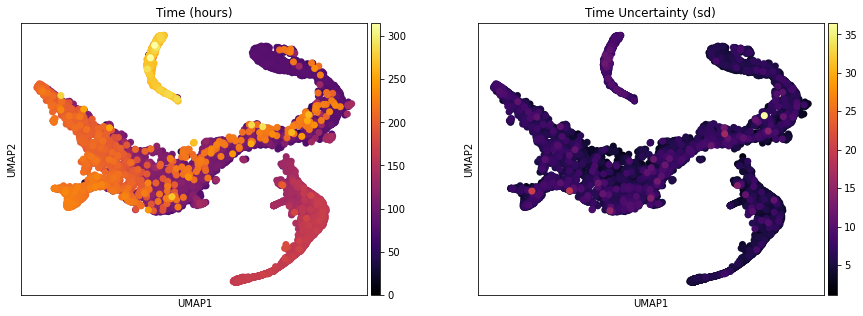

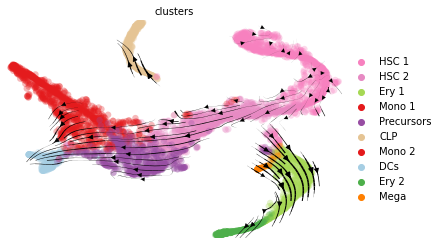

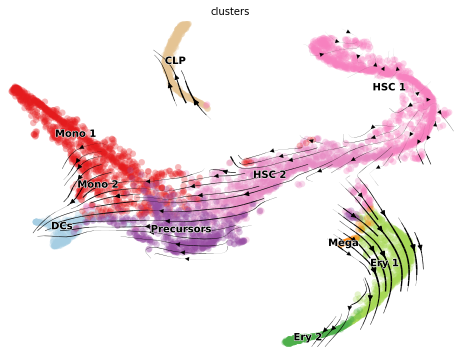

In [1]:
import scvelo as scv
import scanpy as sc
import cell2fate as c2f
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import torch
import unitvelo as utv
method = 'cell2fate'
datasets = ['HumanBoneMarrow', 'Pancreas_with_cc',  'DentateGyrus' , 'MouseBoneMarrow', 'MouseErythroid', 'HumanDevelopingBrain']
batch_id = [None, None, None, 'sequencing.batch', 'Sanger_sample_ID']
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'
i = 0
dataset = datasets[i]
adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                remove_clusters = [], min_shared_counts = 20, n_var_genes= 3000)
if batch_id[i]:
    c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced',
                                          batch_key = batch_id[i])
else:
    c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')    
n_modules = c2f.utils.get_max_modules(adata)
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = n_modules, Tmax_prior={"mean": 200., "sd": 100.})
mod.train()
adata = mod.export_posterior(adata)
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(save_dir + 'c2f_plots/' + dataset + '_UMAP_Time.png')
mod.compute_and_plot_total_velocity(adata, save = False, delete = False)
# Calculate performance metrics:
file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
ground_truth = pickle.load(file)
metrics = utv.evaluate(adata, ground_truth, 'clusters', 'Velocity')
if exists(save_dir + dataset + '_CBDC_scores.csv'):
    tab = pd.read_csv(save_dir + dataset + '_CBDC_scores.csv', index_col = 0)
else:
    tab = pd.DataFrame(columns = list(metrics['Cross-Boundary Direction Correctness (A->B)'].keys()) + ['Mean'],
             index = [method])
cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
            for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
tab.loc[method,:] = cb_score + [np.mean(cb_score)]
tab.to_csv(save_dir + dataset + '_CBDC_scores.csv')
metrics = utv.evaluate(adata, ground_truth, 'clusters', 'Velocity')
if exists(save_dir + dataset + '_ICC_scores.csv'):
    tab = pd.read_csv(save_dir + dataset + '_ICC_scores.csv', index_col = 0)
else:
    tab = pd.DataFrame(columns = list(np.unique(np.concatenate(ground_truth))) + ['Mean'],
             index = [method])
icc_score = [np.mean(metrics['In-cluster Coherence'][x]) for x in np.unique(np.concatenate(ground_truth))]
tab.loc[method,:] = icc_score + [np.mean(icc_score)]
tab.to_csv(save_dir + dataset + '_ICC_scores.csv')
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax)
plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_' + method + '.png')